# Sigma(CT) vs. sigma(GT)

In [22]:
import pandas as pd
import seaborn as sns
import sys
sys.path.append('../..')
from data_import import*
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy as sp
from helper import*
from plot_params import*
from paths import*

In [23]:
pp = PlotParams()
paths = paths()

In [24]:
f4_path = paths.f4_path + 'NOGTHSH/'
fig_save_path = paths.plot_save_path + '/permuted_phi/'
GT_223_225 = 'NOGTHSH_ACROSS_SESSIONS_GT_train_on_223_225.csv'
perm_phi = 'NOGTHSH_LEARNING_CURVES_D8_D9_permute_alter_sequences3_23_09_14.csv'

In [41]:
D9GT_tag, D9GT = import_and_transform_data(f4_path, GT_223_225)
#print (D9GT_tag)

In [42]:
permuted_phi_tag, permuted_phi = import_and_transform_data(f4_path, perm_phi)
# print (permuted_phi_tag)

In [43]:
#########################
### Drop RTs aboove 3 std. 
D9GT = drop_RTs_above_3std_below_180(D9GT)
permuted_phi = drop_RTs_above_3std_below_180(permuted_phi)

In [44]:
permuted_phi.loc[permuted_phi['ini'].str.contains('alt1'), 'phi_seq'] = 'alt1'
permuted_phi.loc[permuted_phi['ini'].str.contains('alt2'), 'phi_seq'] = 'alt2'
permuted_phi.loc[permuted_phi['ini'].str.contains('alt3'), 'phi_seq'] = 'alt3'
permuted_phi.loc[permuted_phi['ini'].str.contains('alt4'), 'phi_seq'] = 'alt4'
permuted_phi.loc[permuted_phi['ini'].str.contains('D9_seq'), 'phi_seq'] = 'D9-seq'
permuted_phi.loc[permuted_phi['ini'].isin(['saw', 'scissors', 'camino', 'silkroad']), 'phi_seq'] = 'D8-seq'

In [45]:
def get_rsqr_values(data, phi_seq = True):
    
    if phi_seq == True:
        groupby = ['model', 'participant', 'phi_seq', 'block']
        droplevel_num = 'level_4'
    else:
        groupby = ['model', 'participant', 'block']
        droplevel_num = 'level_3'
    
    corr_matrix = (data.groupby(groupby)
               [['rt', 'rt_predicted']]
               .corr()
              )
    corr_matrix.reset_index(inplace = True)
    corr_matrix.drop([droplevel_num, 'rt'], axis = 1, inplace = True)
    matrix = corr_matrix.loc[corr_matrix['rt_predicted'] !=1]
    matrix['r_sqr'] = matrix.rt_predicted**2
    matrix.drop('rt_predicted', axis = 1, inplace = True)
    return (matrix)

In [46]:
D9GT_rsqr = get_rsqr_values(D9GT, phi_seq=False)
D9GT_rsqr = D9GT_rsqr.loc[D9GT_rsqr['block']> 200]
D9GT_rsqr['phi_seq'] = 'D9GT'
permuted_phi_rsqr = get_rsqr_values(permuted_phi, phi_seq = True)

## Concat the two frames



In [47]:
permuted_phi_rsqr2 = pd.concat([D9GT_rsqr, permuted_phi_rsqr], ignore_index=True, sort=False)
permuted_phi_rsqr2.drop('model', axis=1, inplace=True)

In [48]:
permuted_phi_rsqr_averaged = (permuted_phi_rsqr2
                                                .groupby(['phi_seq', 'participant'])
                                                .mean()
                                                 .drop('block', axis = 1)
                                                .unstack(0)
                                                .droplevel(0, axis = 1)
                                                .reset_index()
                             )
permuted_phi_rsqr_averaged.columns.name = None

## T-test: sigma(D8) differs from zero

In [49]:
freedom = permuted_phi_rsqr_averaged['D9-seq'].shape[0]-1
t_val, p_val = sp.stats.ttest_1samp(permuted_phi_rsqr_averaged['D9-seq'], popmean = 0) ## one-tailed lehetne
print(f'One sample t-test p-value: {p_val:.3f}{get_stars(p_val)}, t-value: {t_val:.3f}.')
print ('DF = ', freedom)

One sample t-test p-value: 0.000***, t-value: 7.083.
DF =  24


## T-test: GT differs from zero

In [50]:
freedom = permuted_phi_rsqr_averaged['D9-seq'].shape[0]-1
t_val, p_val = sp.stats.ttest_1samp(permuted_phi_rsqr_averaged['D9GT'], popmean = 0) ## one-tailed lehetne. 
print(f'One sample t-test p-value: {p_val:.3f}{get_stars(p_val)}, t-value: {t_val:.3f}.')
print ('DF = ', freedom)

One sample t-test p-value: 0.000***, t-value: 10.815.
DF =  24


## Paired t-test to compare sigma(D8CT) and GT

In [51]:
freedom = permuted_phi_rsqr_averaged['D9GT'].shape[0]-1
t_val, p_val = sp.stats.ttest_rel(permuted_phi_rsqr_averaged['D9-seq'], permuted_phi_rsqr_averaged['D9GT'])
print(f'Paired t-test p-value: {p_val:.3f}{get_stars(p_val)}, t-value: {t_val:.3f}, df: {freedom}')

Paired t-test p-value: 0.000***, t-value: 5.446, df: 24


# Plotting solution 
https://stackoverflow.com/questions/60164606/connecting-jittered-data-points-with-lines-seaborn-python

## Mean and std for sigma(D8CT) and GT

In [52]:
mean = permuted_phi_rsqr_averaged['D9-seq'].mean()
std = permuted_phi_rsqr_averaged['D9-seq'].std()
print(f'Sigma(D8CT) mean: {mean:.3f}, std: {std:.3f}')

mean = permuted_phi_rsqr_averaged['D9GT'].mean()
std = permuted_phi_rsqr_averaged['D9GT'].std()
print(f'GT mean: {mean:.3f}, std: {std:.3f}')

Sigma(D8CT) mean: 0.075, std: 0.053
GT mean: 0.019, std: 0.009


In [53]:
jitter = 0.05
perm_phi_x_jitter = pd.DataFrame(np.random.normal(loc=0,
                                                  scale=jitter, 
                                                  size=permuted_phi_rsqr_averaged.values.shape),
                                                  columns=permuted_phi_rsqr_averaged.columns)
## ennek a sornak az a lényege, hogy növekvő értékűvé tegye a random noise data-t. 
## Tehát az első oszlophoz 0-t, a másidikhoz 1-et adok hozzá hozzá. 
perm_phi_x_jitter[['D9-seq', 'D9GT']] += np.array([-0.2, 1])

## Hasonlóan az előzőhöz, az alt sequence-eket elosztom a 0-1 közötti range-en. 
perm_phi_x_jitter[['alt1', 'alt2', 'alt3','alt4']] += np.arange(len(permuted_phi_rsqr_averaged[['alt1', 'alt2', 'alt3','alt4']].columns))/4 



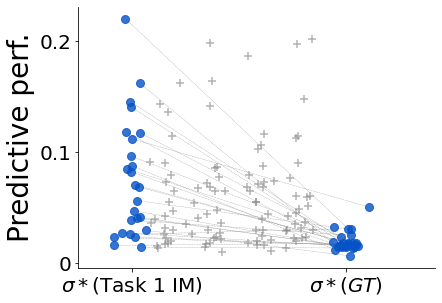

In [54]:
fig, ax = plt.subplots(figsize = pp.figsize, facecolor = 'white')
for col in permuted_phi_rsqr_averaged[['D9-seq', 'D9GT']]:
    ax.plot(perm_phi_x_jitter.loc[:,col], permuted_phi_rsqr_averaged[col], 'o', alpha = 0.8,
            ms=pp.markersize_matplotlib, color = pp.basic_color)
ax.set_xticks([-0.2, 1])
#ax.set_xticklabels([r'$\sigma*$(Task 1 IM)', r'$\sigma(GT)$'], fontsize =pp.ticklabsize)
ax.set_xticklabels([r'$\sigma*$(Task 1 IM)', r'$\sigma*(GT)$'], fontsize =pp.ticklabsize)
ax.set_xlim(-0.5,1.5)

ax.set_yticks([0, 0.1, 0.2])
ax.set_yticklabels([0, 0.1, 0.2], fontsize = pp.ticklabsize)

for idx in permuted_phi_rsqr_averaged.index:
    ax.plot(perm_phi_x_jitter.loc[idx,['D9-seq','D9GT']],
            permuted_phi_rsqr_averaged.loc[idx,['D9-seq','D9GT']],
            color = 'grey', 
            linewidth = 0.3, linestyle = '--', zorder=-1)
    
    
    
    ax.scatter(perm_phi_x_jitter.loc[idx,['alt1','alt2', 'alt3', 'alt4']],
               permuted_phi_rsqr_averaged.loc[idx,['alt1','alt2', 'alt3', 'alt4']],
                                       marker = '+',
                                       s = 55,
                                       color = 'grey', 
                                       alpha = 0.6,
                                       label = r'$\sigma*$(Alternative IMs)')

        
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
#plt.legend(by_label.values(), by_label.keys(), frameon = True, fontsize = 20, loc = (0,1.05));

plt.ylabel(r'Predictive perf.', fontsize = pp.axlabsize);


In [55]:
fig.savefig(paths.plot_save_path + '/manuscript_plots_standard/' +'subjective_belief_sigma_GT.pdf', bbox_inches='tight')
fig.savefig(paths.plot_save_path + '/manuscript_plots_standard/' +'subjective_belief_sigma_GT.png', bbox_inches='tight')